<a href="https://www.kaggle.com/code/mrsalty/grocery-image-classifier-custom-mlp-vs-resnet18?scriptVersionId=273134976" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Grocery image classifier: custom MLP vs ResNet18

The goal of this notebook is to implement a neural network that classifies smartphone pictures of products found in grocery stores.
We will divide in 2 steps:

1- implement from scratch a baseline neural network for image classification.
2- Fine-Tune ResNet-18 on the dataset provided.


## Preliminaries: the dataset



The dataset contains natural images of products taken with a smartphone camera in different grocery stores:



<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>


The products belong to the following 43 classes:

```

0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

Let's download the dataset from GitHub

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (264/264), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6295 (from 2)
Receiving objects: 100% (6559/6559), 116.26 MiB | 48.39 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [3]:
class GroceryStoreDataset(Dataset):
    def __init__(self, split: str, transform=None) -> None:
        super().__init__()
        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()
        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []
        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))
        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design our own network

We will implement our own convolutional neural network for image classification and train it on `GroceryStoreDataset`. Our aim is to reach a classification accuracy on the **validation** split of **around 60%**.

## Part 2: ResNet-18

We will use a pretrained **ResNet-18** model on `GroceryStoreDataset` using PyTorch. We will approach in 2 steps:

1. First, fine-tune the Resnet-18 with the same training hyperparameters used for our best model in the first step.

1. Second, we will tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Our aim is to  obtain a classification accuracy on the **validation** split **between 80 and 90%**.

# Part 1: Design our own network

We'll begin with a basic Convolutional Neural Network and progressively enhance its architecture, we'll analyze its characteristics and iteratively introduce new components, explaining the reasoning behind each addition. Finally, we'll review the training results of all models to draw insights from the observed outcomes.

In [4]:
import torch
print("Using torch", torch.__version__)

Using torch 2.6.0+cu124


In [5]:
import random
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time

from torch.optim import Adam
from torch.utils.data import random_split, DataLoader
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from torchvision.models import ResNet18_Weights

def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.
    Args:
        seed: the seed to use.

    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

In [6]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


## \> Step 1: Simple CNN Baseline

We’ll start with a very basic CNN architecture with only a few layers:

- Single convolutional layer with 16 filters, followed by a ReLU activation.
- Max pooling layer to reduce spatial dimensions.
- Fully Connected layer to map features to class scores.

In [7]:
class GroceryNetV1(nn.Module):

    def __init__(self, num_classes):
        super(GroceryNetV1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16 * 64 * 64, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## \> Step 2: Stacking More Convolutional Layers

To capture more complex patterns, we’ll add 4 Convolutional Layers with increased filters. It was empirically observed that, given the limited size of the GroceryStoreDataset dataset, stacking more than 5 Convolutional Layers wouldn't significantly impact performance.

In [8]:
class GroceryNetV2(nn.Module):
    def __init__(self, num_classes):
        super(GroceryNetV2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(2304, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

## \> Step 3: Batch Normalization + 1 FC Layer + Global Average Pooling

- Batch Normalization was applied to improve network stability and convergence. While the impact is limited due to the small batch size (which can cause fluctuations), it still helps the model converge more reliably.
- An additional Fully Connected Layer was added to the classifier. This expansion aims to enhance the model's capacity to generalize by allowing it to learn more complex features through multiple network stages.
- Global Average Pooling was used before the FC layers, reducing the number of parameters. This approach not only simplifies the model but also enhances generalization by focusing on feature importance rather than spatial details.

In [9]:
class GroceryNetV3(nn.Module):
    def __init__(self, num_classes):
        super(GroceryNetV3, self).__init__()

        # Convolutional layers with batch normalization
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## \> Step 4: DropOut + Linear Learning Rate Scheduler

To reach closer to our target accuracy few steps were finally taken:

- Dropout: Two Dropout layers have been added: one with a rate of 0.2 before the first fully connected layer and another with a rate of 0.4 before the final output layer. This should help mitigate overfitting by randomly deactivating neurons during training, forcing the network to learn more robust features rather than relying on specific activations.

- Linear Learning Rate Scheduler was applied to gradually reduce the learning rate over the epochs. This approach helps maintain training stability, especially in later stages, by making smaller updates as the model starts to converge, thus avoiding overshooting minima in the loss landscape.

In [10]:
class GroceryNetV4(nn.Module):

    def __init__(self, num_classes):
        super(GroceryNetV4, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=1,  stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        # Global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # FC layers
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(256, 512)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(512, num_classes)


    def forward(self, x):
        # Convolutional layers
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        # GAP
        x = self.global_avg_pool(x)

        # Flatten before the FC layers
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

## \> Pre-Processing

Data Augmentation and some image pre-processing is added before training each model. Although not having a remarkable impact in the overall accuracy scores it still helped in reaching the goal of 60% validation accuracy.

The following steps were taken to optimize image quality for improved model training:

- **Random Flipping**:  

  Applying random flips on both horizontal and vertical axes provided the model with varied perspectives of the images. This augmentation strategy helped prevent the model from overfitting on specific orientations, leading to improved generalization on unseen data and a noticeable rise in validation accuracy.

- **Image Sharpening**:  

  Since part of the images in the dataset suffered from blur, sharpening was applied as a preprocessing step to enhance edge clarity and make objects more distinct. This step was essential in helping the model capture finer details that could otherwise be lost in blurry images, thus significantly boosting recognition accuracy.

- **Contrast Enhancement**:  

  Increasing the contrast of the images helped in distinguishing objects more effectively by enhancing visual differences between regions. With sharper contrasts, the model was better able to recognize key features, which further contributed to improved generalization.

## Train Models

### Network Parameters and Rationale

- **Batch Size** (16):<br/>
    - Small batch size consumes less resources but has a less smooth convergence, while acting as reguralizer factor.
<br/>
- **Early Stopping** (`Patience=5`):<br/>
  - Prevents overfitting by halting training if validation performance plateaus for 5 epochs.
<br/>
- **Learning Rate** (`initial_lr=0.001`) and Optimizer (Adam):<br/>
  - Adam optimizer is suitable for adaptive learning rates.
  - The learning rate of 0.001 is commonly effective for Adam, providing a good balance of convergence speed and stability.
<br/>
- **Learning Rate Scheduler** (`LinearLR`):<br/>
  - Gradually decreases learning rate from `1.0` to `0.00001` over all epochs, encouraging the model to stabilize in later stages for optimal final performance. This is used in `GroceryNetV5` model only.

In [11]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, measure_loss=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.measure_loss = measure_loss # defines if using val_loss or val_accuracy

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif self.measure_loss == True and (score > self.best_score):
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        elif self.measure_loss == False and (score < self.best_score):
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [12]:
# Train model
def train_model_custom(model, train_loader, val_loader, num_epochs, criterion, scheduler, optimizer, early_stopping):

    # Initialize data structs to store losses and accuracies
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []
  num_epochs_run = 0
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  for epoch in range(num_epochs):

      # Training phase
      model.train()
      correct_train = 0
      total_train = 0
      running_loss = 0.0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)
          optimizer.zero_grad()  # Clear gradients
          outputs = model.forward(images)  # Forward pass
          loss = criterion(outputs, labels)  # Calculate loss
          loss.backward()  # Backpropagation
          optimizer.step()  # Optimization step
          running_loss += loss.item() * images.size(0)

          _, predicted = torch.max(outputs, 1)

          correct_train += (predicted == labels).sum().item()
          total_train += labels.size(0)

      train_loss = running_loss / len(train_loader.dataset)
      train_accuracy = correct_train / total_train
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation phase
      model.eval()  # Set model to evaluation mode
      correct_val = 0
      total_val = 0
      val_running_loss = 0.0

      with torch.no_grad():  # No need to track gradients during validation
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)

              outputs = model(images)
              loss = criterion(outputs, labels)

              val_running_loss += loss.item() * images.size(0)
              _, predicted = torch.max(outputs, 1)
              correct_val += (predicted == labels).sum().item()
              total_val += labels.size(0)

      val_loss = val_running_loss / len(val_loader.dataset)
      val_accuracy = correct_val / total_val
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      # Print the statistics
      print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val_loss: {val_loss:.4f}, Val_accuracy: {val_accuracy:.4f}')

      # Increase epoch
      num_epochs_run = num_epochs_run + 1

      # lr update
      if scheduler != None:
          scheduler.step()

      # Check early stopping
      early_stopping(val_loss)
      if early_stopping.early_stop:
          print("Early stopping triggered.")
          break

  return train_losses, val_losses, train_accuracies, val_accuracies, num_epochs_run

In [13]:
# Training params
num_epochs = 30
initial_lr = 0.001
image_size = 128
patience = 5
batch_size = 16

In [14]:
# Transformations for training
def get_train_transform():
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAdjustSharpness(0.5, p=0.5),
        transforms.RandomAutocontrast(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet mean/std
    ])

# Transformations for validation
def get_validation_transform():
    return transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet mean/std
    ])

In [15]:
# Prepare model with data
def get_model_version(version):
    print('-'*30)
    print(f'Training model: GroceryNet{version}')
    print('-'*30)

    # Initialize datasets
    train_dataset = GroceryStoreDataset(split="train", transform=get_train_transform())
    val_dataset = GroceryStoreDataset(split="val", transform=get_validation_transform())

    # Number of classes
    num_classes = train_dataset.get_num_classes()

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Early stopping
    early_stopping = EarlyStopping(patience=patience)

    # Versioned model
    model = version_map[version](num_classes=num_classes)

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    # Learning rate scheduler (only V4)
    if version == 'V4':
        scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.00001, total_iters=num_epochs)
    else:
        scheduler = None

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define loss function
    criterion = nn.CrossEntropyLoss()

    return model, train_loader, val_loader, num_epochs, criterion, scheduler, optimizer, early_stopping

In [16]:
def reset_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

In [17]:
# Mapping function to different model versions (v1-v5)
model_versions  = [
    'V1',
    'V2',
    'V3',
    'V4']

version_map = {
    'V1': GroceryNetV1,
    'V2': GroceryNetV2,
    'V3': GroceryNetV3,
    'V4': GroceryNetV4
}

# Data structures for plotting
train_accuracy_all_models = []
val_accuracy_all_models = []
train_loss_all_models = []
val_loss_all_models = []
num_epochs_run_all_models = []

for i, version in enumerate(model_versions):
    reset_seeds(i)

    # Get model
    model, train_loader, val_loader, num_epochs, criterion, scheduler, optimizer, early_stopping = get_model_version(version)

    # Train model
    train_losses, val_losses, train_accuracies, val_accuracies, num_epochs_run = train_model_custom(model, train_loader, val_loader, num_epochs, criterion, scheduler, optimizer, early_stopping)

    # Store results for plotting
    train_accuracy_all_models.append(train_accuracies)
    val_accuracy_all_models.append(val_accuracies)
    train_loss_all_models.append(train_losses)
    val_loss_all_models.append(val_losses)
    num_epochs_run_all_models.append(num_epochs_run)

------------------------------
Training model: GroceryNetV1
------------------------------
Epoch [1/30] - Loss: 5.4370 - Accuracy: 0.2212 - Val_loss: 3.2749, Val_accuracy: 0.1858
Epoch [2/30] - Loss: 2.2386 - Accuracy: 0.3913 - Val_loss: 2.6596, Val_accuracy: 0.2601
Epoch [3/30] - Loss: 1.8421 - Accuracy: 0.4712 - Val_loss: 2.5900, Val_accuracy: 0.3243
Epoch [4/30] - Loss: 1.7206 - Accuracy: 0.5030 - Val_loss: 2.3372, Val_accuracy: 0.3547
Epoch [5/30] - Loss: 1.5122 - Accuracy: 0.5458 - Val_loss: 2.5786, Val_accuracy: 0.3007
Epoch [6/30] - Loss: 1.4472 - Accuracy: 0.5784 - Val_loss: 2.6662, Val_accuracy: 0.2838
Epoch [7/30] - Loss: 1.3797 - Accuracy: 0.5886 - Val_loss: 2.5902, Val_accuracy: 0.3615
Epoch [8/30] - Loss: 1.2581 - Accuracy: 0.6076 - Val_loss: 2.9923, Val_accuracy: 0.3108
Epoch [9/30] - Loss: 1.2715 - Accuracy: 0.6174 - Val_loss: 2.5041, Val_accuracy: 0.3953
Early stopping triggered.
------------------------------
Training model: GroceryNetV2
------------------------------


##  Plot Models Accuracy and Loss



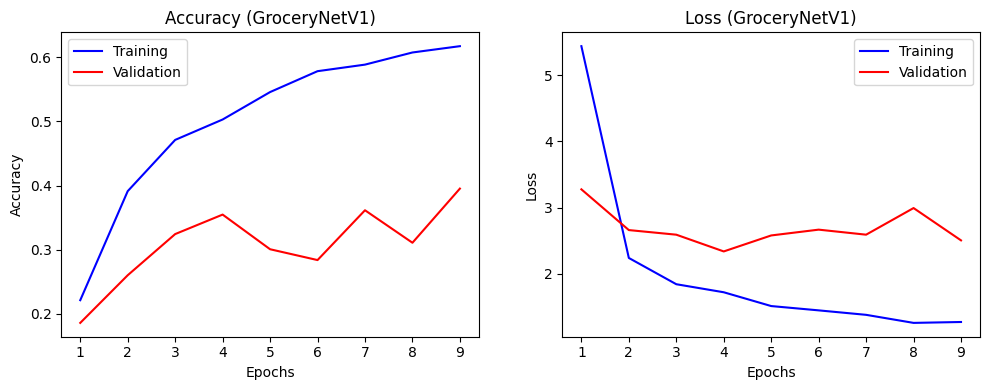

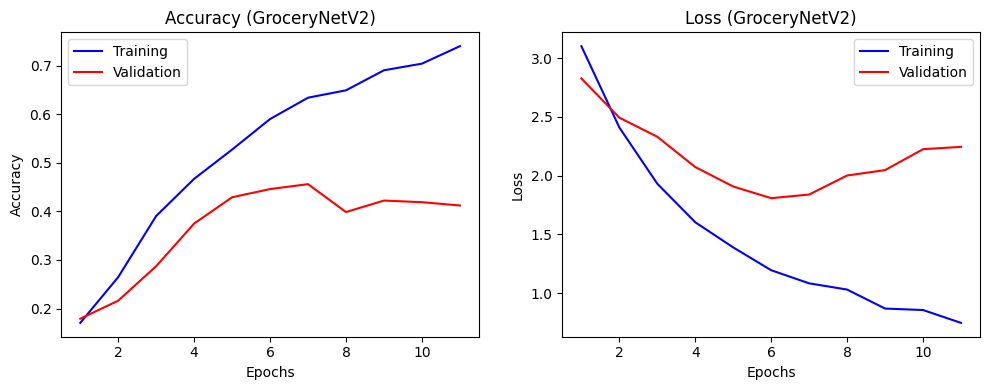

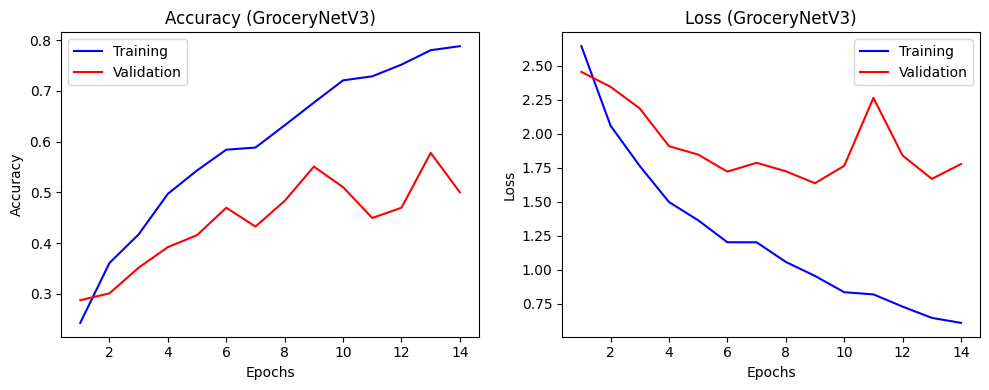

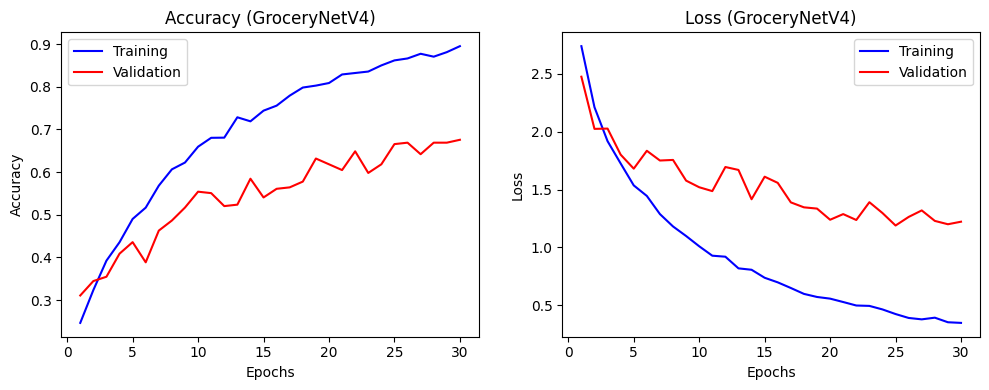

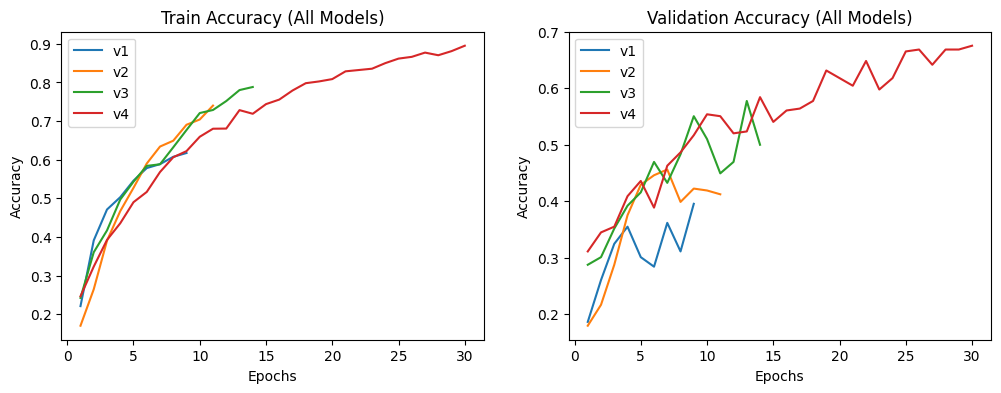

In [18]:
# Plotting the results

for i in range(4):

    epochs = range(1, num_epochs_run_all_models[i] + 1)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy_all_models[i], 'b', label='Training')
    plt.plot(epochs, val_accuracy_all_models[i], 'r', label='Validation')
    plt.title(f'Accuracy (GroceryNetV{i+1})')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_all_models[i], 'b', label='Training')
    plt.plot(epochs, val_loss_all_models[i], 'r', label='Validation')
    plt.title(f'Loss (GroceryNetV{i+1})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.2)
    plt.show()

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
for i in range(4):
    epochs = range(1, num_epochs_run_all_models[i] + 1)
    plt.plot(epochs, train_accuracy_all_models[i], label=f"v{i+1}")
plt.title(f'Train Accuracy (All Models)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
for i in range(4):
    epochs = range(1, num_epochs_run_all_models[i] + 1)
    plt.plot(epochs, val_accuracy_all_models[i], label=f"v{i+1}")
plt.title(f'Validation Accuracy (All Models)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Summary of Improvements

### GroceryNetV1

Serves as the baseline model, using a simple convolutional architecture. It achieves an average validation accuracy of 32%, peaking at 40% before plateauing. The model's shallow design limits its ability to capture complex features, leading to early signs of overfitting. The rapid decline in validation accuracy after early epochs suggests that more sophisticated network designs are necessary for better generalization.

### GroceryNetV2

Improves upon V1 by introducing more convolutional layers, enhancing its ability to learn intricate features. It achieves an average validation accuracy of 38%, with a peak of 46%. While deeper layers contribute to improved feature extraction, overfitting remains a challenge, indicating the need for additional regularization methods to sustain higher performance across epochs.

### GroceryNetV3

Adds Batch Normalization and Global Average Pooling (GAP), significantly boosting generalization. It achieves an average validation accuracy of 51%, peaking at 55%. Batch Normalization stabilizes learning, while GAP reduces overfitting by minimizing the number of parameters. These enhancements demonstrate the effectiveness of architectural modifications in improving model robustness.

### GroceryNetV4

Incorporates Dropout layers with rates of 0.2 and 0.4, further improving regularization. It achieves an average validation accuracy of 60%, peaking at 66%. The use of Dropout effectively mitigates overfitting, resulting in the highest accuracy across all versions. This model highlights the importance of balancing model complexity with appropriate regularization techniques.


| Model | Architecture changes | Validation Accuracy | Train Accuracy |
|---|---|---|---|
|GroceryNetV1|	Simple CNN baseline|	~32%|	~59%|
|GroceryNetV2|	Deeper network with 4 extra conv layers|	~42%|	~70%|
|GroceryNetV3|	Batch Normalization + GAP|	~51%|	~71%|
|GroceryNetV4|	GAP + Dropout + LR Scheduler|	~61%|	~83%|

# Part 2: Fine-Tune ResNet18

Fine tuning ResNet18 keeping GroceryNetV4 parameters fixed.

In [19]:
def train_model_resnet18(early_stop, num_epochs, model, train_loader, val_loader, optimizer, scheduler, criterion, device, early_stopping):

  num_epochs_run = 0
  val_accuracy = 0.0
  val_loss = 0.0
  train_accuracy = 0.0
  train_loss = 0.0
  train_losses = []
  val_losses = []
  train_accuracies = []
  val_accuracies = []

  for epoch in range(num_epochs):
      model.train()  # Set model to training mode
      correct_train = 0
      total_train = 0
      running_loss = 0.0
      val_running_loss = 0.0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = model(images)
          loss = criterion(outputs, labels)

          # Backward pass and optimization
          optimizer.zero_grad()

          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs, 1)
          correct_train += (predicted == labels).sum().item()
          total_train += labels.size(0)

      train_loss = running_loss / len(train_loader.dataset)
      train_accuracy = correct_train / total_train
      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation phase
      model.eval()
      all_preds = []
      all_labels = []
      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              loss = criterion(outputs, labels)
              val_running_loss += loss.item() * images.size(0)
              _, preds = torch.max(outputs, 1)
              all_preds.extend(preds.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

      val_loss = val_running_loss / len(val_loader.dataset)
      val_accuracy = accuracy_score(all_labels, all_preds)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {train_loss:.4f} - Accuracy: {train_accuracy:.4f} - Val_loss: {val_loss:.4f}, Val_accuracy: {val_accuracy:.4f}')

      num_epochs_run = num_epochs_run + 1

      # lr update
      if scheduler != None:
        scheduler.step()

      # Check early stopping
      if early_stop:
        early_stopping(val_accuracy) # use validation accuracy as metric for ES, as we want to maximize it
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

  return model, train_losses, val_losses, train_accuracies, val_accuracies, num_epochs_run

In [20]:
def set_parameter_requires_grad(model, feature_extracting):
  params_to_update = list(model.parameters())
  if feature_extracting:
      params_to_update = []
      for name,param in model.named_parameters():
          if param.requires_grad == True:
              params_to_update.append(param)
  print(f"Params to learn: {len(list(params_to_update))}")
  return params_to_update

## \> Step 1: Fine-Tune ResNet18 with baseline model parameters.

Parameters inherited from custom model:
- `image_size` = 128
- `batch_size` = 16
- `num_epochs` = 30
- `patience` = 5
- `optimizer` = `Adam`
- `LR scheduler` = `Linear (1.0 to 0.0001)`
- `Data Augmentation`:
  -  `RandomHorizontalFlip`
  -  `RandomVerticalFlip`
  -  `RandomRotation`
  -  `RandomAdjustSharpness`
  -  `RandomAutocontrast`

In [21]:
# Model params
image_size = 128
batch_size = 16
num_epochs = 30
patience = 5

reset_seeds(42)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define transformations for the training and validation sets
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define loss function
criterion = nn.CrossEntropyLoss()

# Initialize datasets
train_dataset = GroceryStoreDataset(split="train", transform=train_transform)
val_dataset = GroceryStoreDataset(split="val", transform=val_transform)

# Data Loaders
train_loader_resnet_1 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_resnet_1 = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet-18 model
model_resnet_1 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet_1.to(device)

# Modify the last layer to match the number of classes in the GroceryStoreDataset
num_classes = train_dataset.get_num_classes()
model_resnet_1.fc = nn.Linear(model_resnet_1.fc.in_features, num_classes)

# Move the model to the device
model_resnet_1 = model_resnet_1.to(device)

# Early stopping
early_stopping = EarlyStopping(patience=patience, measure_loss=False)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [22]:
# Fine tuning

print('Fine Tuning Resnet-18...')
params_to_update = set_parameter_requires_grad(model_resnet_1, feature_extracting=False)
optimizer = torch.optim.Adam(model_resnet_1.parameters(), lr=initial_lr)
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.0001, total_iters=num_epochs)
model_resnet_1, train_losses_resnet_1, val_losses_resnet_1, train_accuracies_resnet_1, val_accuracies_resnet_1, num_epochs_run_resnet_1 = train_model_resnet18(True, num_epochs, model_resnet_1, train_loader_resnet_1, val_loader_resnet_1, optimizer, scheduler, criterion, device, early_stopping)

Fine Tuning Resnet-18...
Params to learn: 62
Epoch [1/30] - Loss: 1.9747 - Accuracy: 0.4705 - Val_loss: 2.3726, Val_accuracy: 0.3345
Epoch [2/30] - Loss: 1.0099 - Accuracy: 0.6883 - Val_loss: 1.8780, Val_accuracy: 0.5304
Epoch [3/30] - Loss: 0.7097 - Accuracy: 0.7845 - Val_loss: 1.7245, Val_accuracy: 0.5236
Epoch [4/30] - Loss: 0.4639 - Accuracy: 0.8602 - Val_loss: 2.3281, Val_accuracy: 0.4831
Epoch [5/30] - Loss: 0.3901 - Accuracy: 0.8769 - Val_loss: 1.8214, Val_accuracy: 0.5642
Epoch [6/30] - Loss: 0.3178 - Accuracy: 0.9038 - Val_loss: 1.7447, Val_accuracy: 0.5743
Epoch [7/30] - Loss: 0.2029 - Accuracy: 0.9345 - Val_loss: 1.6869, Val_accuracy: 0.6182
Epoch [8/30] - Loss: 0.2492 - Accuracy: 0.9239 - Val_loss: 1.5856, Val_accuracy: 0.5709
Epoch [9/30] - Loss: 0.1105 - Accuracy: 0.9633 - Val_loss: 1.7384, Val_accuracy: 0.5743
Epoch [10/30] - Loss: 0.1404 - Accuracy: 0.9545 - Val_loss: 2.0361, Val_accuracy: 0.5507
Epoch [11/30] - Loss: 0.1035 - Accuracy: 0.9674 - Val_loss: 1.9675, Val_ac

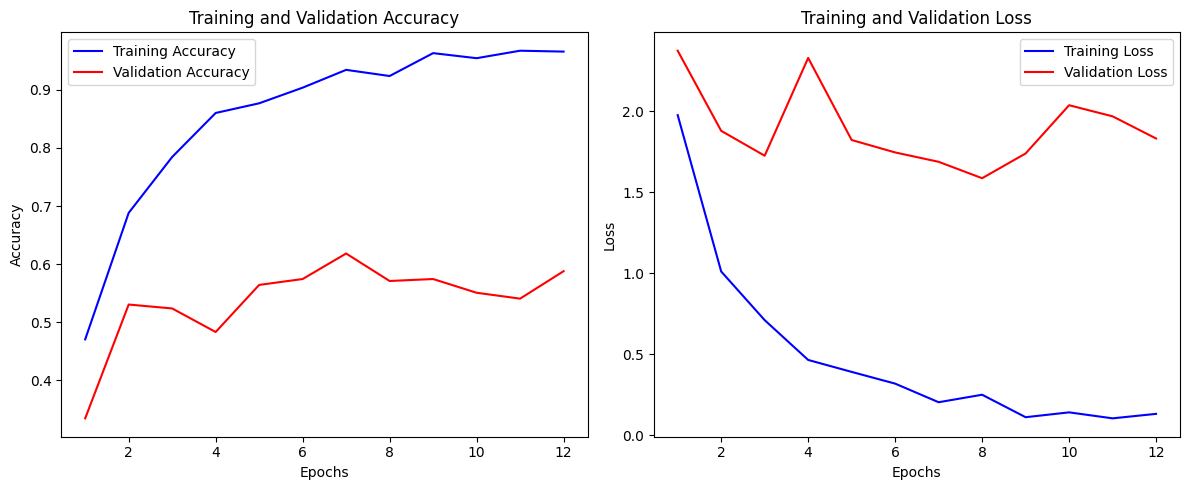

In [23]:
# Plotting the results
epochs = range(1, num_epochs_run_resnet_1 + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies_resnet_1, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies_resnet_1, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_resnet_1, 'b', label='Training Loss')
plt.plot(epochs, val_losses_resnet_1, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## \> Step 2: Fine-Tune ResNet-18 with updated parameters

### Pramaters updates and motivation

1. **Image Size: 128 → 224**  
   Matching the input size to 224 (ResNet-18's original ImageNet size) allows the model to utilize its pre-trained weights more effectively, capturing finer details and improving accuracy.

2. **Batch Size: 16 → 128**  
   A larger batch size provides a more stable gradient estimate, leading to smoother training dynamics and faster convergence.

3. **Patience: 5 → 3**  
   No need for extra patience in the early stopping config as the updated params make the model converge much faster.

4. **Optimizer: Adam → SGD with Momentum (0.99)**  
   Switching to SGD with high momentum enables more controlled, stable updates, reducing oscillations and improving convergence stability for fine-tuning.

5. **Learning Rate Scheduler: Linear Decay → None**  
   Removing the scheduler allows the learning rate to stay consistent, supporting a steady convergence without the potential instability from early learning rate reductions.

6. **Data Augmentation: RandomHorizontalFlip**  
   Limiting augmentation to RandomHorizontalFlip reduces noise while still promoting some robustness, allowing the model to converge faster on dataset-specific features.

### Parameters list:
- `image_size` = 224
- `batch_size` = 128
- `num_epochs` = 30
- `patience` = 5
- `optimizer` = `SGD with momentum (0.99)`
- `LR scheduler` = `none`
- `Data Augmentation`:
  -  `RandomHorizontalFlip`

In [24]:
# Model params
image_size = 224
batch_size = 128
num_epochs = 30
patience = 3

# Define transformations for the training and validation sets
train_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define loss function
criterion = nn.CrossEntropyLoss()

# Initialize datasets
train_dataset = GroceryStoreDataset(split="train", transform=train_transform)
val_dataset = GroceryStoreDataset(split="val", transform=val_transform)

# Data Loaders
train_loader_resnet_2 = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader_resnet_2 = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained ResNet-18 model
model_resnet_2 = models.resnet18(weights=ResNet18_Weights.DEFAULT)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet_2.to(device)

# Modify the last layer to match the number of classes in the GroceryStoreDataset
num_classes = train_dataset.get_num_classes()
model_resnet_2.fc = nn.Linear(model_resnet_2.fc.in_features, num_classes)

# Move the model to the device
model_resnet_2 = model_resnet_2.to(device)

# Early stopping via validationa accuracy
early_stopping = EarlyStopping(patience=patience, measure_loss=False)

In [25]:
# Fine tuning
print('Fine Tuning Resnet-18...')
reset_seeds(90)
params_to_update = set_parameter_requires_grad(model_resnet_2, feature_extracting=False)
optimizer = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.99)
model_resnet_2, train_losses_resnet_2, val_losses_resnet_2, train_accuracies_resnet_2, val_accuracies_resnet_2, num_epochs_run_resnet_2 = train_model_resnet18(True, num_epochs, model_resnet_2, train_loader_resnet_2, val_loader_resnet_2, optimizer, None, criterion, device, early_stopping)

Fine Tuning Resnet-18...
Params to learn: 62
Epoch [1/30] - Loss: 3.3164 - Accuracy: 0.1621 - Val_loss: 3.1051, Val_accuracy: 0.2770
Epoch [2/30] - Loss: 2.0954 - Accuracy: 0.4795 - Val_loss: 2.2538, Val_accuracy: 0.4561
Epoch [3/30] - Loss: 1.1537 - Accuracy: 0.7360 - Val_loss: 1.5812, Val_accuracy: 0.5878
Epoch [4/30] - Loss: 0.6438 - Accuracy: 0.8519 - Val_loss: 1.2891, Val_accuracy: 0.6926
Epoch [5/30] - Loss: 0.3772 - Accuracy: 0.9163 - Val_loss: 1.0210, Val_accuracy: 0.7264
Epoch [6/30] - Loss: 0.2166 - Accuracy: 0.9500 - Val_loss: 0.9108, Val_accuracy: 0.7534
Epoch [7/30] - Loss: 0.1346 - Accuracy: 0.9712 - Val_loss: 0.8893, Val_accuracy: 0.7331
Epoch [8/30] - Loss: 0.0830 - Accuracy: 0.9807 - Val_loss: 0.8496, Val_accuracy: 0.7399
Epoch [9/30] - Loss: 0.0483 - Accuracy: 0.9913 - Val_loss: 0.8293, Val_accuracy: 0.7703
Epoch [10/30] - Loss: 0.0344 - Accuracy: 0.9943 - Val_loss: 0.8474, Val_accuracy: 0.7703
Epoch [11/30] - Loss: 0.0243 - Accuracy: 0.9977 - Val_loss: 0.7809, Val_ac

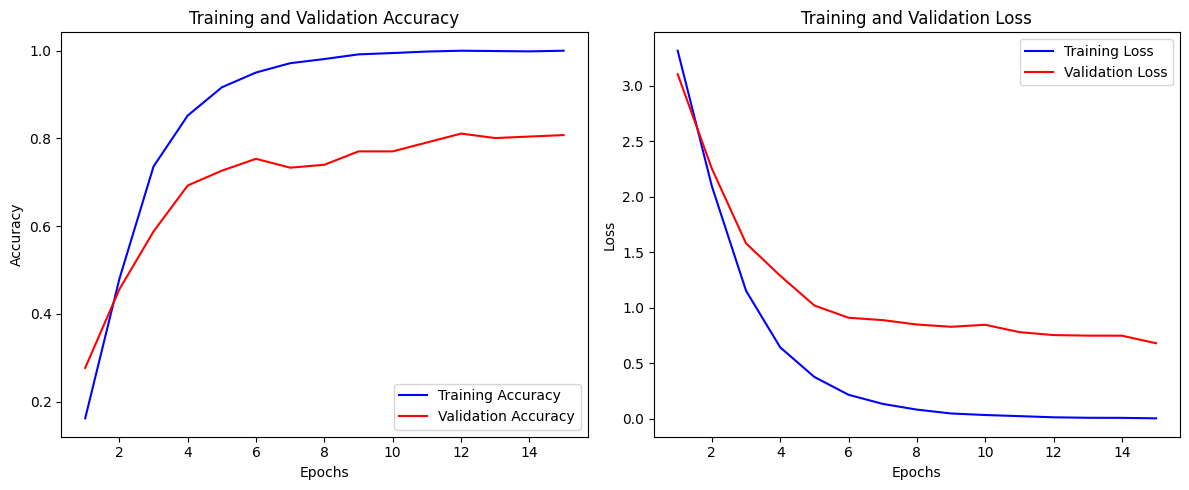

In [26]:
# Plotting the results
epochs = range(1, num_epochs_run_resnet_2 + 1)

# accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies_resnet_2, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies_resnet_2, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses_resnet_2, 'b', label='Training Loss')
plt.plot(epochs, val_losses_resnet_2, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

## The End